<a href="https://colab.research.google.com/github/Azad77/py4researchers/blob/main/FourCastNet_A_practical_introduction_to_a_state_of_the_art_deep_learning_global_weather_emulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# FourCastNet: A practical introduction to a state-of-the-art deep learning global weather emulator

Author(s):
*   Jaideep Pathak, NVIDIA, jpathak@nvidia.com
*   Shashank Subramanian, LBNL, shashanksubramanian@lbl.gov
*   Peter Harrington, LBNL, pharrington@lbl.gov
*   Thorsten Kurth, NVIDIA, tkurth@nvidia.com
*   Andre Graubner, NVIDIA, agraubner@nvidia.com
*   Morteza Mardani, NVIDIA, mmardani@nvidia.com
*   David Hall, NVIDIA, dhall@nvidia.com
*   Karthik Kashinath, NVIDIA, kkashinath@nvidia.com
*   Anima Anandkumar, NVIDIA, aanandkumar@nvidia.com


This notebook is a tutorial for running FourCastNet, a state-of-the-art global high-resolution weather model surrogate, to generate short time-scale forecasts of important atmospheric variables.

# Table of Contents


*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


<a name="overview"></a>
# Overview

This tutorial provides examples to demonstrate the general workflow of working with global atmospheric data and using FourCastNet, a deep learning based weather model, to obtain short to medium-range forecasts of crucial atmospheric variables such as surface wind velocities. FourCastNet can perform these forecasts in a matter of seconds, orders of magnitudes faster and more energy efficient than numerical weather prediction models with accuracy close to that of the best NWP models based on partial differential equation solvers. FourCastNet is the current state-of-the-art deep learning-based surrogate for weather models operating at an unprecedented resolution of 25km. FourCastNet is built using standard machine learning libraries and can be deployed in inference easily. Here, we aim to demonstrate to our users the following:
* work with global weather data from the most comprehensive atmpospheric reanalysis public dataset ERA5 (data assimilated predictions of the historical global atmoshpheric state).
* use FourCastNet on inputs from this dataset to generate short-time scale forecasts of several important atmospheric variables in a matter of seconds.
* visualize the global predictions and compute key metrics to evaluate the forecast skill.
* capture several different types of significant extreme events such as hurricanes and atmospheric rivers.

FourCastNet was trained using significant computational resources that are not always readily available to the academic research community. The trained model weights, code and datasets are shared freely in order to enable broader access to our research. This tutorial is a step towards increasing the accessibility of our work.

Reference:
1. [Pathak el al., 2022](https://arxiv.org/abs/2202.11214)
2. [Github](https://github.com/NVlabs/FourCastNet)

<a name="climate-impact"></a>
# Climate Impact
Accurate, reliable, and efficient means of forecasting global weather patterns are of paramount importance to our ability to mitigate and adapt to climate change. Currently, real-time weather forecasting requires repeated numerical simulation and data assimilation cycles on dedicated supercomputers, which restricts the ability to make reliable, high-resolution forecasts to a handful of organizations. However, recent advances in deep learning, specifically the FourCastNet model, have shown that data-driven approaches can forecast important atmospheric variables with excellent skill and comparable accuracy to standard numerical methods, but at orders-of-magnitude lower computational and energy cost during inference, enabling larger ensembles for better probabilistic forecasts. Forecasting these atmospheric variables can have important implications to various areas such as wind and water resource planning, extreme atmospheric events (hurricanes, atmospheric rivers, heat waves) prediction for disaster prepardeness.

We envision continuous improvements and development of FourCastNet. This, we hope, will enable the leap from accurate medium-range weather forecasts to seasonal and sub-seasonal forecasts all the way up to long-term probabilistic projections of future climate scenarios conditioned on key inputs such as the rising CO2 concentration.

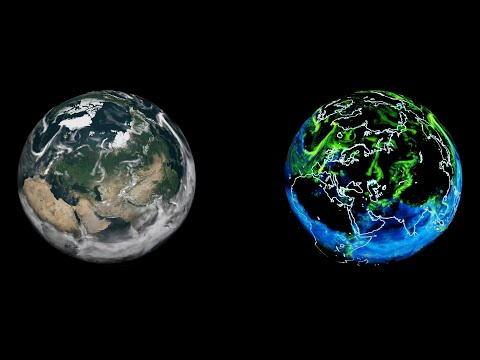

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('nuT_U1AQz3g')

<a name="target-audience"></a>
# Target Audience

The intended audience for this tutorial is anyone interested in using deep learning for research in climate science as well as theoretical and operational weather forecasting. Meteorologists and researcher practitioners in numerical weather prediction, climate science, and earth science will have the most immediate applications for models like FourCastNet, which forecasts atmospheric dynamics with accuracy and speed. Beyond scientific domains, stakeholders in wind energy resource planning, water resource planning, and disaster preparedness may also be interested in tools such as FourCastNet.
Because the earth sciences domain has a lot of rich, extremely high-resolution datasets that have different characteristics from typical natural image or video datasets, this tutorial would also be of interest to the general machine learning community. ML practitioners who wish to build better spatiotemporal modeling neural network architectures would benefit from the introduction to the FourCastNet codebase with its well-curated dataset, SOTA accuracy, performance intensive data loading and distributed computing workflows.



<a name="background-and-prereqs"></a>
# Background & Prerequisites
Basic experience in ML models and PyTorch. Prior background in atmospheric science is not expected.

In [1]:
# Install the ruamel library using pip
#!pip install ruamel

# Import necessary libraries
import os  # For interacting with the operating system
import sys  # For interacting with the Python interpreter
import time  # For time-related functions
import numpy as np  # For numerical operations
import h5py  # For reading and writing HDF5 files
import torch  # PyTorch, a deep learning framework
import torchvision  # Torchvision, a library for computer vision tasks built on PyTorch
import torch.nn as nn  # Neural network modules and layers in PyTorch
import matplotlib.pyplot as plt  # For creating plots and visualizations

<a name="software-requirements"></a>
# Software Requirements
Colab provides a PyTorch environment with the bulk of the necessary Python packages. The [offical FourCastNet Dockerfile](https://github.com/NVlabs/FourCastNet/blob/master/docker/Dockerfile) specifies the additional packages needed to run the code, but since Colab doesn't support Docker we install these via pip below.

In [2]:
# Skip the below if already installed
!pip install ruamel.yaml einops timm

# Clone FourCastNet repository from GitHub
!git clone https://github.com/NVlabs/FourCastNet.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

<a name="data-description"></a>
# Data Description
  FourCastNet was trained on the publicly available [ERA5](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) dataset, provided by the European Center for Medium-range Weather Forecasts (ECMWF). ECMWF is a premier operational and research organization at the cutting edge of Numerical Weather Prediction. The ERA5 dataset consists of hourly estimates of forecasts of several atmoshperic variables at a [latitude and longitude resolution of 0.25 degrees](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference), from the surface of the earth to roughly 100 km altitude. ERA5 is an atmospheric reanalysis dataset and is the result of an optimal combination of observations from various measurement sources and the output of a numerical weather prediction model using a Bayesian estimation process called data-assimilation. The dataset is essentially a reconstruction of the optimal estimate of the observed history of the Earth’s atmosphere. While the ERA5 dataset has several prognostic variables available at 37 vertical levels with an hourly resolution, computational and data limitations along with other operational considerations for DL models restricts our choice, based on physical reasoning, to a subset of these available variables. The current release of FourCastNet is trained on 20 prognostic variables (see reference for further details, all variables are also described in this notebook). The ERA5 dataset predictions are defined on a spherical geometry which is interpolated to a latitude-longitude representation. Following this, each of these 20 variables is represented as a 2D field of shape (721x1440) pixels. Further, we also subselect these predictions at a temporal resolution of 6 hours for computational reasons. Hence, the complete dataset consists of tensors at 6 hourly intervals of shape (20x721x1440). While we do not train the model in this notebook, we show users the evaluation pipeline. For this, we subselect few timesteps from a testing year of 2018 for illustrative purposes.

Interested users are encouraged to download all the rest of the processed 2018 dataset from the Globus download link at the github [page](https://github.com/NVlabs/FourCastNet). Users are also encouraged to use the helper scripts provided in the github code to pre-process their own ERA5 data for use with FourCastNet.

## Data Download
The following downloads a sample of the data that will fit in Colab's available disk space. As mentioned before, we take a few timesteps from the 2018 test set as demonstrative examples.

The directory structure of the downloaded data reflects that of the [full FourCastNet dataset](https://github.com/NVlabs/FourCastNet) available for download, but is missing the train and validation sets.

In [3]:
# The following three lines are shell commands executed in a Jupyter notebook or similar environment using the "!" syntax.
# They download a compressed file from a specified URL, extract its contents, and then remove the compressed file.

!wget https://portal.nersc.gov/project/m4134/ccai_demo.tar  # Download the compressed file from the specified URL.
!tar -xvf ccai_demo.tar  # Extract the contents of the downloaded file.
!rm ccai_demo.tar  # Remove the downloaded compressed file after extraction to save space.

--2024-03-23 19:53:05--  https://portal.nersc.gov/project/m4134/ccai_demo.tar
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.108, 128.55.206.109, 128.55.206.111, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3998497644 (3.7G) [application/x-tar]
Saving to: ‘ccai_demo.tar’

ccai_demo.tar       100%[===================>]   3.72G   124MB/s    in 38s     

2024-03-23 19:53:42 (102 MB/s) - ‘ccai_demo.tar’ saved [3998497644/3998497644]

./ccai_demo/
./ccai_demo/additional/
./ccai_demo/additional/stats_v0/
./ccai_demo/additional/stats_v0/longitude.npy
./ccai_demo/additional/stats_v0/precip/
./ccai_demo/additional/stats_v0/precip/time_means.npy
./ccai_demo/additional/stats_v0/global_means.npy
./ccai_demo/additional/stats_v0/global_stds.npy
./ccai_demo/additional/stats_v0/latitude.npy
./ccai_demo/additional/stats_v0/land_sea_mask.npy
./ccai_demo/additional/stats_v0/time_means.npy
./ccai

In [4]:
# data and model paths
data_path = "./ccai_demo/data/FCN_ERA5_data_v0/out_of_sample"  # Path to the directory containing data files
data_file = os.path.join(data_path, "2018.h5")  # File containing the data for the year 2018
model_path = "./ccai_demo/model_weights/FCN_weights_v0/backbone.ckpt"  # Path to the trained model weights
global_means_path = "./ccai_demo/additional/stats_v0/global_means.npy"  # Path to the file containing global means statistics
global_stds_path = "./ccai_demo/additional/stats_v0/global_stds.npy"  # Path to the file containing global standard deviations statistics
time_means_path = "./ccai_demo/additional/stats_v0/time_means.npy"  # Path to the file containing time means statistics
land_sea_mask_path = "./ccai_demo/additional/stats_v0/land_sea_mask.npy"  # Path to the file containing land-sea mask data

In [5]:
# Insert the code repository into the Python path
sys.path.insert(1, './FourCastNet/')

# Import the YParams class from the utils module within the code repository
from utils.YParams import YParams

In [6]:
# Importing necessary libraries
from FourCastNet.utils import YParams

# Path to the configuration file
config_file = "./FourCastNet/config/AFNO.yaml"

# Name of the configuration within the file
config_name = "afno_backbone"

# Loading the configuration parameters from the file
params = YParams.YParams(config_file, config_name)

# Printing the type of neural network architecture specified in the configuration
print("Model architecture used = {}".format(params["nettype"]))


Model architecture used = afno


## Data Exploration

Here we can inspect the features and spatial structure of some important variables by plotting 2D visualizations. We list the order of atmospheric variables along the channel dimension for reference, and plot snapshots of the 10m horizontal wind (u10), 2m temperature, 500 hPa geopotential height (z500), and total column water vapor (tcwv). Clearly, each variable contains unique characteristics and intrinsic scales; for example, z500 exhibits much smoother features in general compared to the surface-level varaibles which are strongly affected by terrain and coastlines.

The variable keys are as follows:

* u10: zonal wind at 10m from surface
* v10: meridional wind at 10m from surface
* t2m: temperature at 2m from surface
* sp: surface pressure
* msl: pressure reduced to mean sea level
* tcwv: total / integrated column of atmospheric water vapor content
* u1000 (850, 500): zonal wind at pressure level 1000hPa (850hPa, 500hPa)
* v1000 (850, 500): meridional wind at pressure level 1000hPa (850hPa, 500hPa)
* t1000 (850, 500): temperature at pressure level 1000hPa (850hPa, 500hPa)
* z1000 (850, 500, 50): geopotential height at pressure level 1000hPa (850hPa, 500hPa, 50hPa)
* r500, r850: relative humidity at 500hPa, 850hPa


For more information on atmospheric variables, see the [ECMWF Parameter database](https://apps.ecmwf.int/codes/grib/param-db) or the copernicus climate data store catalogue of [single level](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) and [pressure level](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview) variables.




Total data shape: (40, 21, 721, 1440)


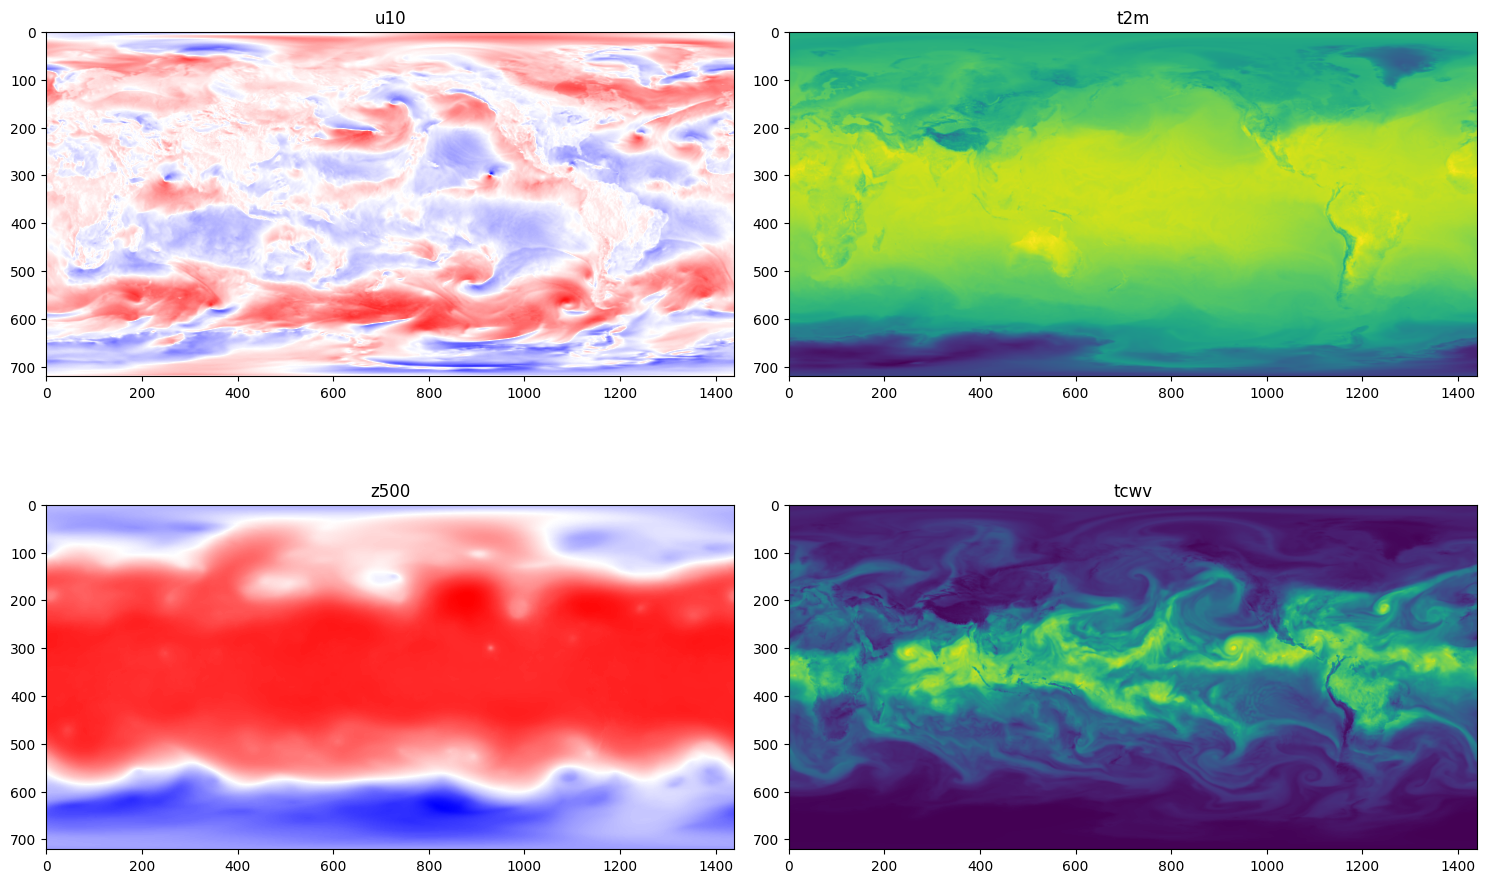

In [7]:
# The ordering of atmospheric variables along the channel dimension is predefined.
# Here are the variables in the order they are stored:
variables = ['u10',    # 10-meter U wind component
             'v10',    # 10-meter V wind component
             't2m',    # 2-meter temperature
             'sp',     # Surface pressure
             'msl',    # Mean sea level pressure
             't850',   # Temperature at 850 hPa
             'u1000',  # U wind component at 1000 hPa
             'v1000',  # V wind component at 1000 hPa
             'z1000',  # Geopotential height at 1000 hPa
             'u850',   # U wind component at 850 hPa
             'v850',   # V wind component at 850 hPa
             'z850',   # Geopotential height at 850 hPa
             'u500',   # U wind component at 500 hPa
             'v500',   # V wind component at 500 hPa
             'z500',   # Geopotential height at 500 hPa
             't500',   # Temperature at 500 hPa
             'z50',    # Geopotential height at 50 hPa
             'r500',   # Relative humidity at 500 hPa
             'r850',   # Relative humidity at 850 hPa
             'tcwv']   # Total column water vapor

# Opening the HDF5 file containing the data
sample_data = h5py.File(data_file, 'r')['fields']

# Printing the total shape of the data
print('Total data shape:', sample_data.shape)

# Index of the timestep to visualize
timestep_idx = 0

# Creating subplots for visualization
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Looping through selected variables for visualization
for i, varname in enumerate(['u10', 't2m', 'z500', 'tcwv']):
    # Choosing colormap based on variable name
    cm = 'bwr' if varname == 'u10' or varname == 'z500' else 'viridis'

    # Getting the index of the variable in the data
    varidx = variables.index(varname)

    # Plotting the variable data
    ax[i//2][i%2].imshow(sample_data[timestep_idx, varidx], cmap=cm)
    ax[i//2][i%2].set_title(varname)

# Adjusting layout
fig.tight_layout()

##Model Loading

We use the default AFNO backbone configuration as our forecasting model. The [AFNO or Adaptive Fourier Neural Operator](https://arxiv.org/abs/2111.13587) is a neural network architecture based on a vision transformer backbone with the self-attention spatial mixing (interaction between different pixels or image patches) replaced by mixing in the Fourier domain. The basic principle of a vision transformer is simple: the input tensor of size $C \times H \times W$ (channel width $C$, height $H$ and width $W$) is projected onto a grid of patches $D \times H/p \times W/p$, where $D$ is the projection embedding dimension and $p$ is the patch size. Each of these projected patches interact with each other (known as spatial mixing operation) in a transfomer block through a learned attention matrix (an $O(N^2)$ operation, with $N$ as number of patches) and the transformer block outputs a tensor of the same size as the input. We refer the user to the original vision transformer paper [Alexey Dosovitskiy et al. 2021](https://arxiv.org/abs/2010.11929) for details. The AFNO overcomes the quadratic complexity of mixing by performing the spatial mixing in the frequency domain using Fast Fourier Transforms and shared weights. We refer the user to [Pathak el al., 2022](https://arxiv.org/abs/2202.11214) for further details on the model architecture.

The model was trained on 64 GPUs for 6 hours using the configs defined here. We load pretrained weights for making our forecasts.

We refer the reader to [Pathak el al., 2022](https://arxiv.org/abs/2202.11214) for FourCastNet benchmark comparisons with state-of-the-art NWP models, i.e., the IFS model of the ECMWF (Figure 6) and prior benchmarks of deep learning data-driven weather models (Figure 10). A comparison of computational cost and energy efficiency is also presented in the referenced preprint in table 2.

![afno](https://drive.google.com/uc?id=1Y0mdVHzNIrPju_IactWUbkEdgchM9C0o)

In [8]:
# Importing necessary modules
from networks.afnonet import AFNONet  # Importing the AFNONet model from the networks module
from collections import OrderedDict  # Importing OrderedDict from the collections module, which will be used for ordered dictionaries

def load_model(model, params, checkpoint_file):
    '''
    Helper function to load model weights

    Args:
    - model: The neural network model
    - params: Any parameters needed for loading
    - checkpoint_file: Path to the checkpoint file

    Returns:
    - model: The loaded model with weights
    '''

    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname)

    try:
        '''
        FourCastNet is trained with distributed data parallel
        (DDP) which prepends 'module' to all keys. Non-DDP
        models need to strip this prefix
        '''
        new_state_dict = OrderedDict()
        for key, val in checkpoint['model_state'].items():
            name = key[7:]  # remove the 'module.' prefix
            if name != 'ged':
                new_state_dict[name] = val
        model.load_state_dict(new_state_dict)
    except:
        '''
        If the stripping of prefix fails, fallback to loading
        the model state dictionary directly
        '''
        model.load_state_dict(checkpoint['model_state'])

    model.eval()  # set to inference mode
    return model

# Check if CUDA (GPU) is available, otherwise use CPU
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

# Define the number of input and output channels
# FourCastNet uses 20 input channels corresponding to 20 prognostic variables
in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)

# Set the number of input and output channels in the parameters
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)

# Load global means and standard deviations for normalization
# These statistics are precomputed from the training data
# and will be used to normalize input and output data
params.means = np.load(global_means_path)[0, out_channels]
params.stds = np.load(global_stds_path)[0, out_channels]

# Load time means which are also used for normalization
# These might represent additional statistics computed per time step
params.time_means = np.load(time_means_path)[0, out_channels]

# load the model
if params.nettype == 'afno':
    model = AFNONet(params).to(device)  # AFNO model
else:
    raise Exception("not implemented")
# load saved model weights
model = load_model(model, params, model_path)
model = model.to(device)

<a name="methodology"></a>
# Methodology

In this section, we describe the different steps to compute forecasts. After this tutorial, users should be able to:
* Prepare ERA5 data in the right format for FourCastNet
* Run FourCastNet inference for timesteps of interest
* Analyze the forecast skill and accuracy on extremes for any atmospheric variable predicted by FourCastNet
* Use FourCastNet to forecast the track of hurricanes

## Get training stats for normalization
First, we load the mean and standard deviation of all variables across the training dataset. This has been precomputed for convenience, as computing this over 40 years can be resource-intensive. Each mean and standard deviation is of size (20,). All the data is standardized with these values. Further, we also load a temporal mean field that represents the mean field of each variable across all the years: this represents the climatology (the general variation of the field over several years). This is used to compute metrics for evaluation, described later. The climatology is a tensor of size 721x1440 for each of the 20 variables. We discard data from the last row from all variables to get a tensor of shape 720x1440.

In [10]:
# Move normalization tensors to GPU
# Load time means: represents climatology
img_shape_x = 720 # width (number of columns)
img_shape_y = 1440 # height (number of rows)

# Means and standard deviations over training data
means = params.means
stds = params.stds

# Load climatological means
time_means = params.time_means  # Temporal mean (for every pixel)

# Normalize the climatological means using the training data statistics
m = torch.as_tensor((time_means - means) / stds)[:, 0:img_shape_x]  # Normalize and select relevant image dimensions
m = torch.unsqueeze(m, 0)  # Add batch dimension
m = m.to(device, dtype=torch.float)  # Move to GPU and set data type

# Standard deviation needed for computation of certain metrics
std = torch.as_tensor(stds[:, 0, 0]).to(device, dtype=torch.float)  # Extract standard deviation values
# Shape verification prints
print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))


Shape of time means = torch.Size([1, 20, 720, 1440])
Shape of std = torch.Size([20])



## Define metrics to evaluate forecast skill
We use the following metrics to evaluate the quality and skill of our predictions:
* Weighted root mean squared error (RMSE) for a forecast variable $v$ at forecast time-step $l$ defined as:
\begin{align}
\mathrm{RMSE}(v, l)= \sqrt{\frac{1}{NM} \sum_{m=1}^{M} \sum_{n=1}^{N} L(m)\left({X}_{\text{pred}}(l)[v,j,k]-{X}_{\text{true}}(l)\left[v, j, k \right]\right)^{2}},
\end{align}
where  ${X}_{\text{pred/true}}(l)\left[v, m, n \right]$ represents the value of predicted (/true) variable $v$ at the location denoted by the grid co-ordinates $(m, n)$ at the forecast time-step $l$. Here, $L(m)$ is a latitude weighting factor to account for the curvature of the field defined on a sphere and is defined as:
\begin{align}
L(m)=\frac{\cos (\operatorname{lat}(m))}{\frac{1}{N_{\text {lat }}} \sum_{m}^{N_{\text {lat }}} \cos (\operatorname{lat}(m))}.
\end{align}
* Weighted anomaly correlation coefficient (ACC) for a forecast variable $v$ at forecast time-step $l$ defined as:
\begin{align}
\mathrm{ACC}(v, l)=\frac{\sum_{m, n} L(m) \tilde{{X}}_{\text{pred}}(l)\left[ v, m, n \right] \tilde{{X}}_{\text{true}}(l)\left[v, m, n\right]}{\sqrt{\sum_{m, n} L(m) \left( \tilde{{X} }_{\text{pred}}(l)\left[v, m, n\right]\right)^{2} \sum_{m, n} L(m) \left(\tilde{{X}}_{\text{true}}(l)\left[v, m, n\right]\right)^{ 2}}},
\end{align}
where $\tilde{{X}}_{\text{pred/true}}(l)\left[v, m, n \right]$ represents the long-term-mean-subtracted value of predicted (true) variable $v$ at the location denoted by the grid co-ordinates $(m, n)$ at the forecast time-step $l$. The long-term mean of a variable is simply the mean value of that variable over a large number of historical samples in the training dataset. The long-term mean-subtracted variables $\tilde{{X}}_{\text{pred/true}}$ represent the anomalies of those variables that are not captured by the long term mean values. The long-term means are precomputed into the time means tensor above.

In [12]:
# Define a function to calculate latitude given a tensor `j` and the total number of latitudes `num_lat`
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    """
    Calculate latitude based on the index `j` and total number of latitudes `num_lat`.

    Parameters:
        j (torch.Tensor): Index representing latitude.
        num_lat (int): Total number of latitudes.

    Returns:
        torch.Tensor: Calculated latitude.
    """
    # Calculate latitude using the formula: 90 - (j * 180 / (num_lat - 1))
    # The formula assumes the latitudes span from 90 degrees (North Pole) to -90 degrees (South Pole)
    return 90. - j * 180. / float(num_lat - 1)
#-----------------------------------------------------#
def latitude_weighting_factor(j: torch.Tensor, num_lat: int, s: torch.Tensor) -> torch.Tensor:
    """
    Calculates latitude weighting factor for a given latitude index 'j'.

    Args:
    - j (torch.Tensor): Index representing latitude.
    - num_lat (int): Total number of latitude indices.
    - s (torch.Tensor): Some parameter.

    Returns:
    - torch.Tensor: Latitude weighting factor.
    """
    # Conversion factor to convert degrees to radians
    deg_to_rad = 3.1416 / 180.

    # Calculating the latitude weighting factor
    # 'lat(j, num_lat)' represents a function to get the latitude for index 'j'
    # 'torch.cos()' calculates the cosine of the latitude in radians
    # 'num_lat * torch.cos(3.1416/180. * lat(j, num_lat))' is the latitude weighting factor
    # divided by 's' to compute the final latitude weighting factor
    return num_lat * torch.cos(deg_to_rad * lat(j, num_lat)) / s
#-------------------------------------------------------------------------#

def weighted_rmse_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Calculates latitude-weighted RMSE for each channel in the predicted and target tensors.

    Args:
    - pred (torch.Tensor): Predicted tensor of size [n, c, h, w].
    - target (torch.Tensor): Target tensor of size [n, c, h, w].

    Returns:
    - torch.Tensor: Latitude-weighted RMSE for each channel.
    """

    # Number of latitude points
    num_lat = pred.shape[2]

    # Generating latitude indices
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)

    # Calculating the sum of cosine values for latitude weighting
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))

    # Calculating latitude weights
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))

    # Computing squared differences, weighted by latitude, and taking the square root
    result = torch.sqrt(torch.mean(weight * (pred - target)**2., dim=(-1,-2)))

    return result
#-------------------------------------------------------------------------------------#

def weighted_acc_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Computes latitude-weighted accuracy for each channel.

    Args:
    - pred (torch.Tensor): Predicted values, should be of size [n, c, h, w].
    - target (torch.Tensor): Target values, should be of size [n, c, h, w].

    Returns:
    - torch.Tensor: Latitude-weighted accuracy for each channel.
    """

    # Calculate the number of latitude points
    num_lat = pred.shape[2]

    # Generate a tensor representing latitude indices
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)

    # Calculate the sum of cosine of latitudes for weighting
    s = torch.sum(torch.cos(3.1416 / 180. * lat(lat_t, num_lat)))

    # Calculate the latitude weighting factor
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))

    # Compute weighted accuracy for each channel
    result = torch.sum(weight * pred * target, dim=(-1, -2)) / torch.sqrt(
        torch.sum(weight * pred * pred, dim=(-1, -2)) * torch.sum(weight * target * target, dim=(-1, -2))
    )

    return result


## Setup autoregressive inference

Obtaining forecasts is done through an autoregressive loop: the initial condition of the atmospheric state is taken from the ERA5 dataset and is recursively passed through the FourCastNet model, i.e., the predicted forecasts are once again fed back into the input stream to get forecasts for several timesteps. We setup a helper function to run autoregressive inference given an initial condition and a prediction/forecast length.

![inf](https://drive.google.com/uc?id=1DvjQ95udGjEmrWjxJvVle4tn8H6Oc0T8)


In [13]:
# autoregressive inference helper

def inference(data_slice, model, prediction_length, idx):
    """
    Function to perform autoregressive inference using a given model.

    Args:
    - data_slice (torch.Tensor): Input data slice for inference.
    - model (torch.nn.Module): Autoregressive model.
    - prediction_length (int): Length of the prediction sequence.
    - idx (int): Index of the channel to focus on during inference.

    Returns:
    - acc_cpu (numpy.ndarray): Accuracy metrics computed during inference.
    - rmse_cpu (numpy.ndarray): Root Mean Square Error metrics computed during inference.
    - predictions_cpu (numpy.ndarray): Predicted values during inference.
    - targets_cpu (numpy.ndarray): Ground truth values used for inference.
    """

    # create memory for the different stats
    n_out_channels = params['N_out_channels']
    acc = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    rmse = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)

    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)


    with torch.no_grad():
        for i in range(data_slice.shape[0]):
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                targets[0,0] = first[0,idx]
                predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            if i < prediction_length - 1:
                predictions[i+1,0] = future_pred[0,idx]
                targets[i+1,0] = future[0,idx]

            # compute metrics using the ground truth ERA5 data as "true" predictions
            rmse[i] = weighted_rmse_channels(pred, tar) * std
            acc[i] = weighted_acc_channels(pred-m, tar-m)
            print('Predicted timestep {} of {}. {} RMS Error: {}, ACC: {}'.format(i, prediction_length, field, rmse[i,idx], acc[i,idx]))

            pred = future_pred
            tar = future

    # copy to cpu for plotting/vis
    acc_cpu = acc.cpu().numpy()
    rmse_cpu = rmse.cpu().numpy()
    predictions_cpu = predictions.cpu().numpy()
    targets_cpu = targets.cpu().numpy()

    return acc_cpu, rmse_cpu, predictions_cpu, targets_cpu



First, we read a slice of data corresponding to the forecast length. Here, the initial condition is at 00:00 hours on October 7, 2018 UTC. This serves as an illustrative example because it highlights Hurricane Michael which underwent rapid intensification during the course of its four day trajectory.
We keep track of a specific channel for visualization purposes downstream; in principle, we can track all channels, but we restrict ourselves to one channel here because of limited GPU memory and RAM on Colab.

In [14]:
# setup data for inference
dt = 1  # Time step (x 6 hours)
ic = 0  # Start the inference from here
prediction_length = 20  # Number of steps (x 6 hours)

# Which field to track for visualization
field = 'u10'
idx_vis = variables.index(field)  # Get the index of the field in the list of variables
# Also prints out metrics for this field

# Get prediction length slice from the data
print('Loading inference data')
print('Inference data from {}'.format(data_file))  # Print the file from which data is loaded
data = h5py.File(data_file, 'r')['fields'][
    ic:(ic + prediction_length * dt):dt,  # Slice data according to the prediction length and time step
    in_channels,  # Channels for input
    0:img_shape_x  # Shape of the image in x dimension
]
print(data.shape)  # Print the shape of the loaded data
print("Shape of data = {}".format(data.shape))  # Print the shape of the loaded data


Loading inference data
Inference data from ./ccai_demo/data/FCN_ERA5_data_v0/out_of_sample/2018.h5
(20, 20, 720, 1440)
Shape of data = (20, 20, 720, 1440)


Before we run inference, we standardize the data with precomputed means and standard deviations. In this tutorial, we keep track of metrics for the field "u10", which represents the horizontal component of the surface wind velocities. The outputs track the weighted RMSE and ACC values for "u10" as a function of timestep.

In [15]:
# Standardize the data by subtracting mean and dividing by standard deviation
data = (data - means) / stds

# Convert the standardized data to a PyTorch tensor and move it to the specified device (GPU) for inference
data = torch.as_tensor(data).to(device, dtype=torch.float) # .to(device): This moves the tensor to the specified device. The device argument can be either "cpu" (central processing unit) or "cuda:x" (where x is the GPU index) depending on where you want to perform the computations.

# Perform inference using the provided function, passing the data, model, prediction length,
# and optionally an index for visualization
acc_cpu, rmse_cpu, predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis)


Predicted timestep 0 of 20. u10 RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 20. u10 RMS Error: 0.5595946907997131, ACC: 0.9900789260864258
Predicted timestep 2 of 20. u10 RMS Error: 0.7682856917381287, ACC: 0.9802854657173157
Predicted timestep 3 of 20. u10 RMS Error: 0.8545156121253967, ACC: 0.9751376509666443
Predicted timestep 4 of 20. u10 RMS Error: 0.9780223369598389, ACC: 0.9663249850273132
Predicted timestep 5 of 20. u10 RMS Error: 1.072445273399353, ACC: 0.9600213170051575
Predicted timestep 6 of 20. u10 RMS Error: 1.2340995073318481, ACC: 0.9463505148887634
Predicted timestep 7 of 20. u10 RMS Error: 1.3775659799575806, ACC: 0.9345251321792603
Predicted timestep 8 of 20. u10 RMS Error: 1.5805352926254272, ACC: 0.9138075709342957
Predicted timestep 9 of 20. u10 RMS Error: 1.7355366945266724, ACC: 0.9003416299819946
Predicted timestep 10 of 20. u10 RMS Error: 1.9263521432876587, ACC: 0.8789011836051941
Predicted timestep 11 of 20. u10 RMS Error: 2.123237133026123, ACC: 0.856

*Historically, this forecast, using numerical weather prediction models, should have required an entire supercomputer with thousands of cores to run; with FourCastNet, the forecast is obtained in a matter of seconds on a single GPU on Colab!*

<a name="results-and-discussion"></a>
# Results & Discussion
Using the saved tensors from our inference run, we can now evaluate our forecasts.

## Get quantitative metrics to evaluate forecasts
We plot the ACC and RMSE as a function of forecast time. In practice, ACC values above 0.6 are considered to be useful forecasts. We observe that, for example, $u_{10}$ shows good performance up to 4 days. Slower moving fields, such as $z_{500}$ (geopotential height) show great performance for much longer time horizons. Users can change the `field` variable name to analyze the results for different atmospheric variables

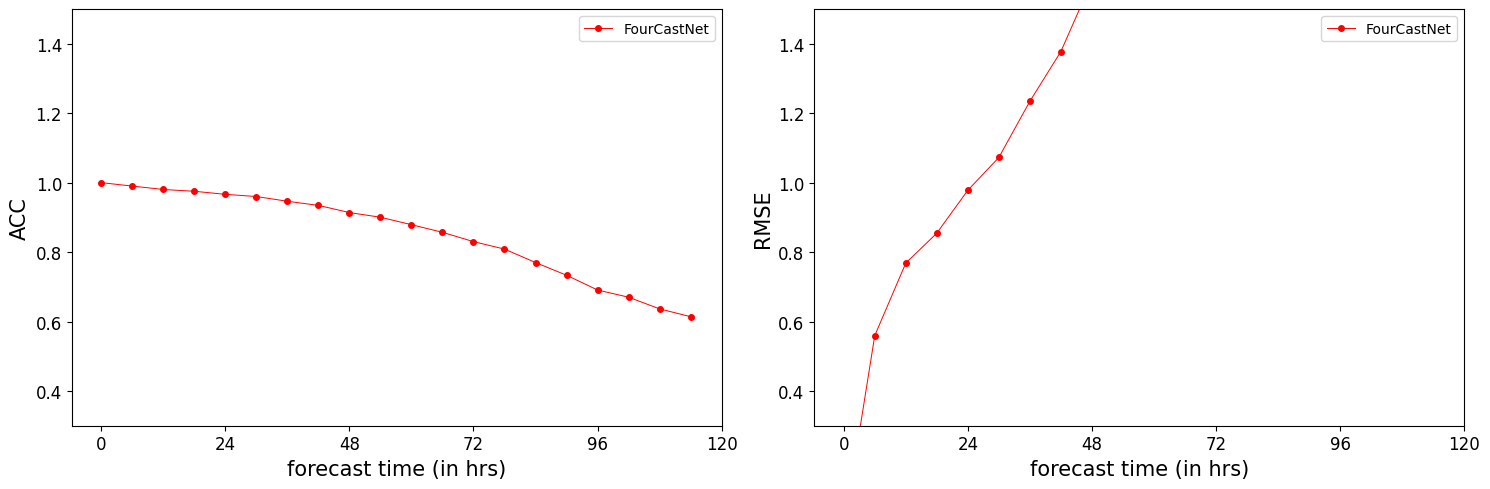

In [19]:
# Plot the accuracy (ACC) and root mean square error (RMSE) metrics
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))  # Create a figure with two subplots
start = 0  # Start index for plotting
end = prediction_length  # End index for plotting; 'prediction_length' denotes forecast length

field = 'u10'  # Define the field to plot, e.g., 'u10' or 'z500' (wind speed at 10m or geopotential height)
idx_metric = variables.index(field)  # Get the index of the chosen field in the 'variables' list

hrs = np.arange(0, end*6, 6)  # Create an array representing forecast hours in intervals of 6 hours
# Plot ACC for the selected field
ax[0].plot(hrs, acc_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
# Plot RMSE for the selected field
ax[1].plot(hrs, rmse_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")

ax[0].legend()  # Add legend to the ACC plot
ax[1].legend()  # Add legend to the RMSE plot

fsz = "15"  # Font size for labels and ticks
xlist = np.arange(0,end*6+24,24)  # Create an array representing x-axis ticks at 24-hour intervals
# Set labels and limits for the x and y axes, and set ticks
for i in range(2):
    ax[i].set_xlabel("forecast time (in hrs)", fontsize=fsz)  # Set x-axis label
    ax[i].set_ylabel("ACC" if i == 0 else "RMSE", fontsize=fsz)  # Set y-axis label
    ax[i].set_ylim(0.3, 1.5)  # Set y-axis limits
    ax[i].set_xticks(xlist)  # Set x-axis ticks
    ax[i].tick_params(axis='both', which='both', labelsize=12)  # Set tick parameters

fig.tight_layout()  # Adjust subplot layout to prevent overlapping


## Visualize forecasts for qualitative assessment
We can visualize the spatiotemporal predictions for the channel tracked ($u_{10}$) and visually compare to the ground truth ERA5. We can observe that the predictions track the ground truth very well.

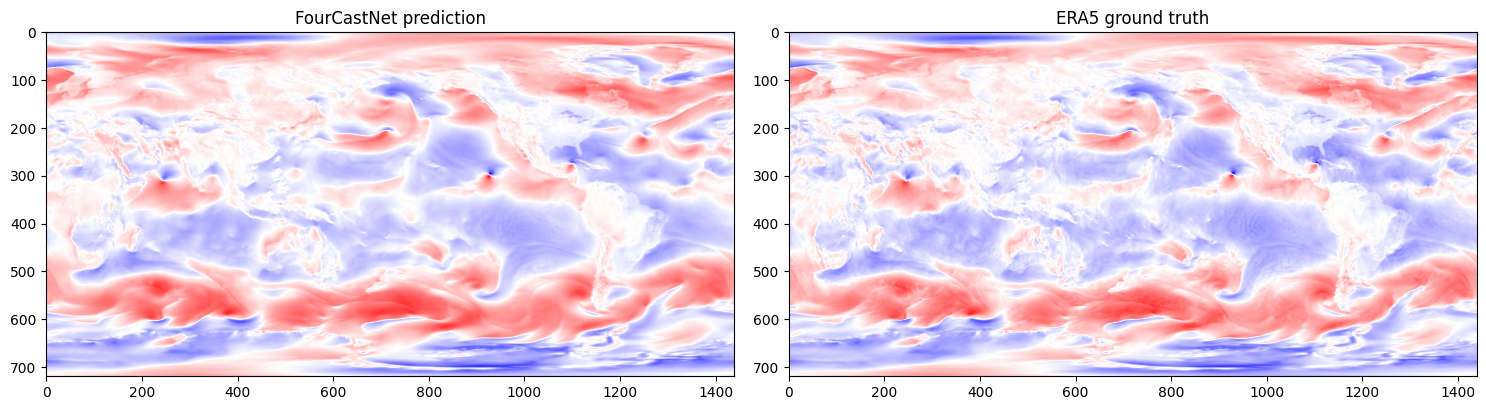

In [21]:
# Visualize spatiotemporal predictions

# Creating a figure with two subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Selecting the time index for visualization
t = 2  # at 2x6 hours lead time

# Displaying the prediction in the first subplot
ax[0].imshow(predictions_cpu[t, 0], cmap="bwr")

# Displaying the ground truth in the second subplot
ax[1].imshow(targets_cpu[t, 0], cmap="bwr")

# Setting titles for each subplot
ax[0].set_title("FourCastNet prediction")  # Title for the prediction subplot
ax[1].set_title("ERA5 ground truth")       # Title for the ground truth subplot

# Adjusting the layout to prevent overlapping of subplots
fig.tight_layout()

## Assess instantaneous extremes
Quantifying extremes is a very important task for predicting rare atmospheric events such as hurricanes, heat waves, and heavy precipitation. We do so by looking at the top quantiles of each field at a given time step. We use 100 logarithmically-spaced quantile bins $Q = 1 - \{10^{-1}, ..., 10^{-4}\}$ (corresponding to percentiles $\{90\%, ..., 99.99\% \}$) to emphasize the most extreme values (generally, the FourCastNet predictions and ERA5 targets match closely up to around the 98$^\mathrm{th}$ percentile). We choose the 99.99$^{\mathrm{th}}$ as the top percentile  bin because percentiles beyond there sample less than 1000 pixels in each image and are subject to more variability.

In [22]:
def quantiles(x, qtile):
    '''
    Helper function to compute quantiles based on a specified quantile of the field.

    Parameters:
        x (numpy.ndarray): Input array with shape (n, c, h, w), where:
            - n: number of samples
            - c: number of channels
            - h: height of the field
            - w: width of the field
        qtile (float or array_like of floats): Quantile or sequence of quantiles to compute, should be between 0 and 1.

    Returns:
        numpy.ndarray: Array containing quantiles computed along the last axis.

    Note:
        - The input array x is reshaped to have shape (n, c, h*w) before computing quantiles.
        - The last axis (axis=-1) represents the spatial dimensions (h*w) of the field.
        - The `squeeze()` function is called to remove axes of length 1 resulting from the reshaping.
    '''
    n, c, h, w = x.shape  # Extracting dimensions of the input array x
    # Reshape the input array x to have shape (n, c, h*w) to treat each spatial location as a separate dimension
    reshaped_x = x.reshape((n,c,h*w))
    # Compute quantiles along the last axis (spatial dimensions) of the reshaped array
    quantiles_result = np.quantile(reshaped_x, q=qtile, axis=-1)
    # Squeeze removes axes of length 1 resulting from the reshaping
    return quantiles_result.squeeze()


Let's compute these 100 bins for both our predictions and ERA5 over all the time steps.

In [27]:
# Define parameters for quantile computation
qs = 100  # Number of quantiles to compute
qlim = 4  # Upper limit of quantile range
qcut = 1  # Lower limit of quantile range
qtile = 1. - np.logspace(-qlim, -qcut, num=qs)  # Generate log-spaced bins for quantiles

# Compute quantiles for the fields saved (channel idx_vis is saved out now)
era5_q = quantiles(targets_cpu, qtile)  # Compute quantiles for ERA5 data
mean_era5 = era5_q.mean(axis=1)  # Compute mean over different time points for ERA5 data
std_era5 = era5_q.std(axis=1)  # Compute standard deviation over different time points for ERA5 data

pred_q = quantiles(predictions_cpu, qtile)  # Compute quantiles for predictions
mean_pred = pred_q.mean(axis=1)  # Compute mean over different time points for predictions
std_pred = pred_q.std(axis=1)  # Compute standard deviation over different time points for predictions

# Print shapes of quantile arrays for ERA5 data and predictions
print(era5_q.shape, pred_q.shape)


(100, 20) (100, 20)


Plotting the quantiles, we observe that the predictions track the extremes well (but do underestimate the extremes from the 90$^{\mathrm{th}}$ percentile)

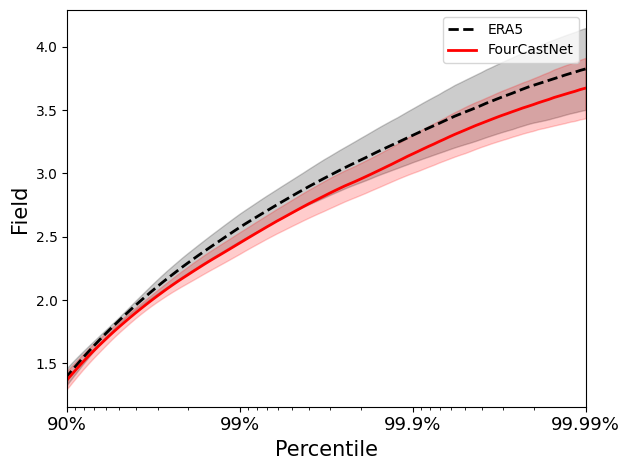

In [29]:
# Plot the extremes
plt.figure()  # Create a new figure
fs = 15  # Font size for labels

# Get the current Axes instance
ax = plt.gca()

# Generate quantiles using logarithmic scale
qtiles = np.logspace(-qlim, -qcut, num=qs)

# Plot mean and standard deviation for ERA5 data
ax.plot(qtiles, mean_era5, 'k--', label='ERA5', lw=2)  # Plot mean ERA5 data
ax.fill_between(qtiles, mean_era5+std_era5, mean_era5-std_era5, alpha=0.2, color='k')  # Fill area between upper and lower bounds for ERA5 data

# Plot mean and standard deviation for FourCastNet predictions
ax.plot(qtiles, mean_pred, 'r-', label='FourCastNet', lw=2)  # Plot mean FourCastNet predictions
ax.fill_between(qtiles, mean_pred+std_pred, mean_pred-std_pred, alpha=0.2, color='r')  # Fill area between upper and lower bounds for FourCastNet predictions

# Set x-axis limits and scale
ax.set_xlim((qtiles[-1], qtiles[0]))  # Set x-axis limits from the last to the first quantile
ax.set_xscale('log')  # Set x-axis scale to logarithmic

# Set x-axis tick marks and labels
ax.set_xticks(ticks=10.**np.arange(-1,-qlim - 1, -1))  # Set tick marks for quantiles
ax.set_xticklabels(labels=['%g%%'%(100.*(1. - 10.**q)) for q in np.arange(-1,-qlim - 1, -1)], fontsize=fs-2)  # Set labels for tick marks as percentages

# Set x-axis label and y-axis label
ax.set_xlabel('Percentile', fontsize=fs)  # Set x-axis label
ax.set_ylabel('Field', fontsize=fs)  # Set y-axis label

# Add legend
ax.legend()

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()

## Hurricane tracking

In this section we demonstrate the use of FourCastNet for forecasting hurricane tracks. We will focus on Michael, a category 5 hurricane on the Saffir-Simpson Hurricane Wind Scale that made landfall in Florida in 2018 and caused
catastrophic damage. Michael started as a tropical depression around October 7, 2018 then underwent rapid intensification in the gulf of Mexico, reaching category 5 status before making landfall in Florida on October 10, 2018.

We can approximate the center of the hurricane by finding the minimum of the mean surface level pressure in the region of the globe where the tropical depression is forming. By recording the coordinates of the msl minima over time, we can record the track of the storm as it intensifies from a depression into catastrophic hurricane. The sample data from 2018 which we've downloaded in this notebook contains the initial condition on October 7, 2018 as the first time index, so we simply need to run autoregressive inference with the model starting there.

In [30]:
# Set the field to track for visualization, in this case, it's mean surface level pressure (msl)
field = 'msl'

# Find the index of the 'msl' field in the list of variables
idx_vis = variables.index(field) # Also prints out metrics for this field

# Perform inference using the provided data and model, predicting a specified length
# The `idx` parameter indicates the index of the field to visualize
acc_cpu_msl, rmse_cpu_msl, predictions_cpu_msl, targets_cpu_msl = inference(data, model, prediction_length, idx=idx_vis)

# Destandardize the predicted and target mean surface level pressure (msl) fields
# Get the mean and standard deviation of the 'msl' field from the parameters
m_msl = params.means[idx_vis, 0]  # Mean
s_msl = params.stds[idx_vis, 0]   # Standard Deviation

# Destandardize the predicted and target mean surface level pressure (msl) fields
pred_msl = s_msl * predictions_cpu_msl + m_msl  # Destandardized forecasted msl
true_msl = s_msl * targets_cpu_msl + m_msl      # Destandardized true msl

# Print the shapes of the destandardized forecasted and true mean surface level pressure (msl) fields
print(pred_msl.shape, true_msl.shape)


Predicted timestep 0 of 20. msl RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 20. msl RMS Error: 38.01778030395508, ACC: 0.9986559152603149
Predicted timestep 2 of 20. msl RMS Error: 55.31365966796875, ACC: 0.9970652461051941
Predicted timestep 3 of 20. msl RMS Error: 61.87911605834961, ACC: 0.9964411854743958
Predicted timestep 4 of 20. msl RMS Error: 77.7435531616211, ACC: 0.9944821000099182
Predicted timestep 5 of 20. msl RMS Error: 87.43624114990234, ACC: 0.9927594065666199
Predicted timestep 6 of 20. msl RMS Error: 107.86058044433594, ACC: 0.9885034561157227
Predicted timestep 7 of 20. msl RMS Error: 125.31631469726562, ACC: 0.984866201877594
Predicted timestep 8 of 20. msl RMS Error: 147.39881896972656, ACC: 0.9790379405021667
Predicted timestep 9 of 20. msl RMS Error: 173.34413146972656, ACC: 0.9707463383674622
Predicted timestep 10 of 20. msl RMS Error: 201.41397094726562, ACC: 0.9600929021835327
Predicted timestep 11 of 20. msl RMS Error: 227.37777709960938, ACC: 0.95043832

Now that we've run inference, let's compute and store the msl minima throughout the forecast period:

In [31]:
# Focus region: Represents the area of interest for tracking Hurricane Michael
x_min = 1081  # Minimum longitude index of the focus region
x_max = 1121  # Maximum longitude index of the focus region
y_min = 201   # Minimum latitude index of the focus region
y_max = 305   # Maximum latitude index of the focus region

# Lists to store predicted and true hurricane track coordinates
track_pred_x = []  # Predicted longitude coordinates of the hurricane track
track_pred_y = []  # Predicted latitude coordinates of the hurricane track
track_true_x = []  # True longitude coordinates of the hurricane track
track_true_y = []  # True latitude coordinates of the hurricane track

t_max = 14  # Number of time steps to track the hurricane (roughly the number of steps to reach landfall)
timeaxis = np.arange(0, t_max)  # Time axis from 0 to t_max-1

# Loop through each time step for tracking the hurricane
for t in range(t_max):
    # Predicted minimum pressure and corresponding coordinates
    min_pressure_predicted = np.min(pred_msl[t, 0, y_min:y_max, x_min:x_max])
    pred_y = np.where(pred_msl[t, 0, y_min:y_max, x_min:x_max] == min_pressure_predicted)[0]
    pred_x = np.where(pred_msl[t, 0, y_min:y_max, x_min:x_max] == min_pressure_predicted)[1]
    track_pred_x.append(pred_x[0])  # Append the predicted longitude coordinate
    track_pred_y.append(pred_y[0])  # Append the predicted latitude coordinate

    # True minimum pressure and corresponding coordinates
    min_pressure_true = np.min(true_msl[t, 0, y_min:y_max, x_min:x_max])
    true_y = np.where(true_msl[t, 0, y_min:y_max, x_min:x_max] == min_pressure_true)[0]
    true_x = np.where(true_msl[t, 0, y_min:y_max, x_min:x_max] == min_pressure_true)[1]
    track_true_x.append(true_x[0])  # Append the true longitude coordinate
    track_true_y.append(true_y[0])  # Append the true latitude coordinate


By plotting the msl minima of the forecast compared to that of the ground truth, we can see the predicted track closely matches the actual observed outcome for this hurricane:

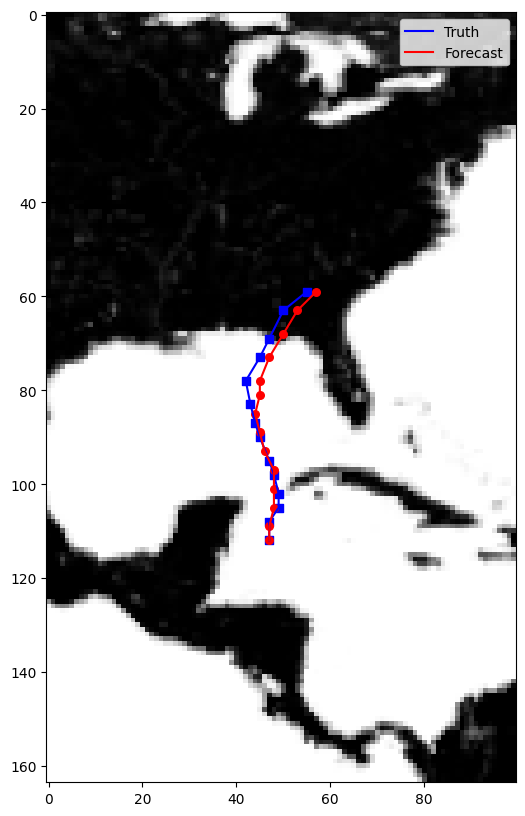

In [32]:
offset = 30  # Offset value used for adjusting the plot boundaries

# Load land-sea mask data and select only the relevant region
lsm = np.load(land_sea_mask_path)[0:720]

# Create a figure with specified size
plt.figure(figsize=(30, 10))

# Get the current axes of the plot
ax = plt.gca()

# Display the land-sea mask within the specified boundaries
ax.imshow(lsm[y_min-offset:y_max+offset, x_min-offset:x_max+offset], cmap='Greys')

# Plot the true track points with markers and lines
plt.scatter(np.array(track_true_x) + offset, np.array(track_true_y) + offset, s=30, marker='s', c='b')
plt.plot(np.array(track_true_x) + offset, np.array(track_true_y) + offset, c='b', label="Truth")

# Plot the predicted track points with markers and lines
plt.scatter(np.array(track_pred_x) + offset, np.array(track_pred_y) + offset, s=30, marker='o', c='r')
plt.plot(np.array(track_pred_x) + offset, np.array(track_pred_y) + offset, c='r', label="Forecast")

# Add a legend to the plot
plt.legend()


While we are somewhat resorce-limited running on Colab, note in general one could run an ensemble of forecasts by perturbing the initial conditions and model predictions with noise. We refer the users to [the paper](https://arxiv.org/abs/2202.11214) for more details on such an approach.

## Limitations
*   One of the limitations of FourCastNet is that it does not perform data assimilation with observations; we are dependent on a dataset such as ERA5 to provide us real-time initial conditions. However, once obtained, the forecasts for a week or two can be generated blazingly fast
*   The current resolution of 25 km is still coarse to capture finer scale structures of sub-grid processes. We would have to go to 5 km scale (and finer) for resolving these. Of course, at these scales, compute and memory challenges are significant. We refer the reader to [Kurth et al. (2022)](https://arxiv.org/abs/2208.05419) for a model-parallel version to deal with these high resolutions. This is still work-in-progress.
* FourCastNet is a fully data-driven model without physics constraints.
This means that the model could be subject to some unphysical instabilities that are not present in traditional numerical weather predicition. We are working on introducing physics constraints into the next version of FourCastNet.
* Currently, FourCastNet is intended as a weather model and its behaviour on climate time scales is not understood well. We, eventually, envision a coupling between a climate model output and FourCastNet in order to understand extreme weather in future climate scenarios.

## Next Steps

In this notebook, we have seen how to format and normalize ERA5 data and run inference with FourCastNet, storing forecast outputs and using them for analysis tasks like evaluating forecast skill, assessing instantaneous extremes, and predicting hurricane tracks. However, these general steps enable users to use FourCastNet for a much wider set of use-cases.

One immediate application of FourCastNet in the data-driven modeling area is to use the pretrained backbone model as a building block or foundation for training other models to make predictions for a specific variable or region of interest. In this setting, FourCastNet outputs can be used as initial or boundary conditions for tasks not included in the general forecasting task used for pretraining. For example, one could train a model to predict a specific variable of interest not included in the main FourCastNet backbone (e.g., 100m winds which may be of interest to wind energy stakeholders), or train a regional high-resolution model which depends on FourCastNet for boundary conditions.

While this notebook did not demonstrate actual model training due to resource constraints, the main FourCastNet repository includes code for training and we encourage users to now work on training the model themselves. This is complementary to the aforementioned idea of adapting FourCastNet for whatever use-cases are most important to a given stakeolder; the pretrained model weights provide a good initialization for fine-tuning, so can even accelerate the time-to-solution even for novel tasks that were not included in the main model training.